# Цифровой прорыв 2021
## Пропавшие самолеты UPDATE

## Задача

Необходимо определить по снимкам, присутствует ли на них самолет. 

Данные для обучения:
- 31080 снимков
 - на 7899 из них есть самолёт
 - 40 из них синтезированы

Тестовый набор:
- 1000 изображений
 - 200 из них содержат признак самолёта
 - 60 изображений с признаком самолёта синтезированы

Данные:
- avia-train.zip - изображения обучающей выборки
- train.csv - разметка обучающей выборки. 
- Признак 'sign': 0 - нет самолета, 1 - есть самолет
- avia-test.zip - изображения тестовой выборки
- test.csv - тестовая выборка (без разметки)
- sample_submission.csv - пример решения

Метрика: ROC AUC

### Обновление от 07.08.2021:

По задаче добавлен расширенный датасет, содержащий дополнительные 100 000 картинок такого же размера, как в исходном датасете. Формат решения не изменился, вам по-прежнему нужно прислать CSV файл с двумя столбцами: sign,filename. Но количество строк в таблице теперь будет 101 000 (1000 из начального датасета + 100 000 из дополнительного). И в столбце sign теперь могут быть вероятности (числа от 0.0 до 1.0).

##### Новые данные:

- avia-test-extended.zip - изображения тестовой выборки (доступен по внешней ссылке) 
- test_extended.csv - тестовая выборка (без разметки)
- sample_submission_extended.csv - пример решения (все ответы = 0)

##### Особенности расчета метрики

Поскольку конкурс идет уже 3 недели, мы решили не обнулять таблицу результатов, то есть все ваши достижения останутся в силе, но теперь вы сможете их немного улучшить. Таким образом, метрика, рассчитанная по первой части данных, остается основной, а дополнительные данные будут слабо влиять на итоговый результат (в третьем знаке после запятой) - исключительно для выявления победителей среди участников, набравших одинаковый балл.

Формула итоговой метрики:


```
score = roc_auc_first + 0,001 * roc_auc_extended
```

где:

roc_auc_first
- метрика ROC AUC, рассчитанная по начальному датасету (первые 1000 строк решения)

roc_auc_extended
- метрика ROC AUC, рассчитанная по дополнительному датасету (последние 100 000 строк решения)

Таким образом, максимальное значение, которое может принять итоговая метрика равно 1,001 ( = 1 + 0,001 * 1).

Для решения с константным ответом (как в sample_submission_extended.csv ) - метрика будет равна 0,5005.

## Импорт библиотек

In [ ]:
import os
import shutil

# from skimage.io import imread
# from skimage.transform import resize
from PIL import Image
import pickle
import cv2

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import datasets, transforms
# from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

!pip freeze > requirements.txt 

Для работы мне понадобится сохранять промежуточные результаты. Для этого, я подключу свой Google-disk и создам рабочую папку.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
WORK_DIR = '/content/gdrive/MyDrive/allcups/allcups_update/'
MODELS = WORK_DIR + 'models/'
METRICS = WORK_DIR + 'metrics/'
SUBMITS = WORK_DIR + 'submits/'
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)
os.makedirs(METRICS, exist_ok=True)
os.makedirs(SUBMITS, exist_ok=True)

Напишем 2 функции для обеспечения воспроизводимости

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id): # передается в параметр DataLoader(...worker_init_fn=seed_worker)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
set_seed(42)

Проверим доступность GPU

In [ ]:
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Wed Aug 11 17:09:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Посмотрим на данные

Я скачала данные и разместила их у себя на Google-disk. Загрузим их в рабочую среду, распакуем архивы и посмотрим, с чем будем работать

In [ ]:
os.chdir('/content/')
!gdown --id 1CYBWX37vgllAPkXeJ_FSZNUwPbMoGLAN

Downloading...
From: https://drive.google.com/uc?id=1CYBWX37vgllAPkXeJ_FSZNUwPbMoGLAN
To: /content/airplanes.zip
34.2MB [00:02, 11.7MB/s]


In [ ]:
!unzip -q /content/airplanes.zip -d data/

In [ ]:
!unzip -q /content/data/avia-train.zip -d data/avia-train

In [ ]:
!unzip -q /content/data/avia-test.zip -d data/avia_test

In [ ]:
for address, dirs, files in os.walk('/content/data'):
  print(address, dirs, len(files))

/content/data ['avia_test', 'avia-train'] 7
/content/data/avia_test ['__MACOSX', 'avia-test'] 0
/content/data/avia_test/__MACOSX ['avia-test'] 1
/content/data/avia_test/__MACOSX/avia-test [] 1000
/content/data/avia_test/avia-test [] 1000
/content/data/avia-train ['avia-train', '__MACOSX'] 0
/content/data/avia-train/avia-train [] 31080
/content/data/avia-train/__MACOSX ['avia-train'] 1
/content/data/avia-train/__MACOSX/avia-train [] 31080


In [ ]:
# удалим лишние папки
shutil.rmtree('/content/data/avia-train/__MACOSX')
shutil.rmtree('/content/data/avia_test/__MACOSX')

In [ ]:
# Скачаем новые тестовые данные
os.chdir('/content/')
!gdown --id 11T5v9Bu9Bxg600fe4NQwKjO_yqCQAviA

Downloading...
From: https://drive.google.com/uc?id=11T5v9Bu9Bxg600fe4NQwKjO_yqCQAviA
To: /content/avia-test-extended.zip
74.5MB [00:00, 91.4MB/s]


In [ ]:
!unzip -q /content/avia-test-extended.zip -d data/avia-test-extended

In [ ]:
for address, dirs, files in os.walk('/content/data/avia-test-extended'):
  print(address, dirs, len(files))

/content/data/avia-test-extended ['avia-test-extended', '__MACOSX'] 0
/content/data/avia-test-extended/avia-test-extended [] 100000
/content/data/avia-test-extended/__MACOSX ['avia-test-extended'] 0
/content/data/avia-test-extended/__MACOSX/avia-test-extended [] 7


In [ ]:
# удалим лишние папки
shutil.rmtree('/content/data/avia-test-extended/__MACOSX')

In [ ]:
TRAIN_DATA = '/content/data/avia-train/avia-train/'
TEST_DATA = '/content/data/avia_test/avia-test/'
UP_TEST_DATA = '/content/data/avia-test-extended/avia-test-extended/'

#### Посмотрим на статистику датасетов

In [ ]:
def img_frame(img_path):
  ends = []
  hs = []
  ws = []
  cs = []
  
  img_files = os.listdir(img_path)

  for img_file in img_files:
    img = Image.open(img_path + img_file)
    img_array = np.array(img)
    # Shape
    hs.append(img_array.shape[0])
    ws.append(img_array.shape[1])
    cs.append(img_array.shape[2])
    # endswith
    ends.append(img_file.split('.')[1])

  image_df = pd.DataFrame({
  'name': img_files,
  'height': hs,
  'width': ws,
  'channels': cs,
  'end': ends
  })

  return image_df

In [ ]:
train_stat = img_frame(TRAIN_DATA)
test_stat = img_frame(TEST_DATA)
up_test_stat = img_frame(UP_TEST_DATA)

In [ ]:
train_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31080 entries, 0 to 31079
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      31080 non-null  object
 1   height    31080 non-null  int64 
 2   width     31080 non-null  int64 
 3   channels  31080 non-null  int64 
 4   end       31080 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [ ]:
test_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      1000 non-null   object
 1   height    1000 non-null   int64 
 2   width     1000 non-null   int64 
 3   channels  1000 non-null   int64 
 4   end       1000 non-null   object
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


In [ ]:
up_test_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   name      100000 non-null  object
 1   height    100000 non-null  int64 
 2   width     100000 non-null  int64 
 3   channels  100000 non-null  int64 
 4   end       100000 non-null  object
dtypes: int64(3), object(2)
memory usage: 3.8+ MB


In [ ]:
# Уникальные значения расширений файлов
print('Расширение файлов обучающей выборки', train_stat.end.unique())
print('Расширение файлов тестовой выборки', test_stat.end.unique())
print('Расширение файлов обновленной тестовой выборки', up_test_stat.end.unique())

Расширение файлов обучающей выборки ['png']
Расширение файлов тестовой выборки ['png']
Расширение файлов обновленной тестовой выборки ['jpeg']


Все файлы имеют расширение $.png$, а файлы обновленной тестовой выборки имеют расширение $.jpeg$

In [ ]:
# Размеры изображений обучающей выборки
train_stat.describe()

,height,width,channels
count,31080.0,31080.0,31080.000000
mean,20.0,20.0,3.001287
std,0.0,0.0,0.035852
min,20.0,20.0,3.000000
25%,20.0,20.0,3.000000
50%,20.0,20.0,3.000000
75%,20.0,20.0,3.000000
max,20.0,20.0,4.000000


In [ ]:
# Размеры изображений тестовой выборки
test_stat.describe()

,height,width,channels
count,1000.0,1000.0,1000.000000
mean,20.0,20.0,3.060000
std,0.0,0.0,0.237606
min,20.0,20.0,3.000000
25%,20.0,20.0,3.000000
50%,20.0,20.0,3.000000
75%,20.0,20.0,3.000000
max,20.0,20.0,4.000000


In [ ]:
# Размеры изображений новой тестовой выборки
up_test_stat.describe()

,height,width,channels
count,100000.0,100000.0,100000.0
mean,20.0,20.0,3.0
std,0.0,0.0,0.0
min,20.0,20.0,3.0
25%,20.0,20.0,3.0
50%,20.0,20.0,3.0
75%,20.0,20.0,3.0
max,20.0,20.0,3.0


Размеры всех изображений $20 х 20$. Но некоторые изображения обучающей и тестовой выборки имеют 4 канала вместо 3-х.

In [ ]:
train_stat[train_stat.channels == 4].count()

name        40
height      40
width       40
channels    40
end         40
dtype: int64

In [ ]:
test_stat[test_stat.channels == 4].count()

name        60
height      60
width       60
channels    60
end         60
dtype: int64

Синтезированные изображения имеют 4 канала вместо 3-х. Выясним, какой канал лишний.

In [ ]:
name_4_ch = train_stat[train_stat.channels == 4].name.iloc[0]

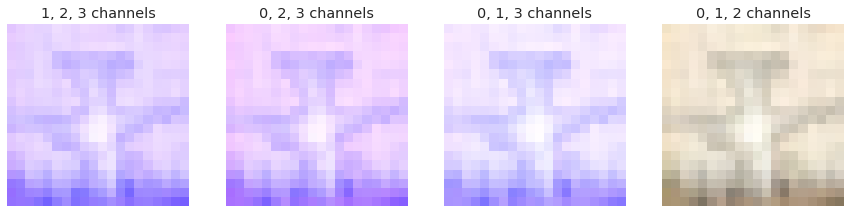

In [ ]:
img = Image.open(TRAIN_DATA + name_4_ch)
img_array = np.array(img)

plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(img_array[:,:,1:])
plt.title('1, 2, 3 channels')

plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(img_array[:,:,[0,2,3]])
plt.title('0, 2, 3 channels')

plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(img_array[:,:,[0,1,3]])
plt.title('0, 1, 3 channels')

plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(img_array[:,:,:3])
plt.title('0, 1, 2 channels')
plt.show;

Последний канал лишний. Необходимо его убрать, а фотографии заменить.

In [ ]:
train_names_4_chan = train_stat[train_stat.channels == 4].name.to_list()
test_names_4_chan = test_stat[test_stat.channels == 4].name.to_list()

def del_channel(lst_names, folder):
  for name in lst_names:
    img = Image.open(folder + name)
    img_array = np.array(img)
    img_array = img_array[:,:,:3]
    img = Image.fromarray(img_array)
    img.save(folder + name)
  print(f'last channel in {len(lst_names)} in {folder} has moved')

In [ ]:
del_channel(train_names_4_chan, TRAIN_DATA)
del_channel(test_names_4_chan, TEST_DATA)

last channel in 40 in /content/data/avia-train/avia-train/ has moved
last channel in 60 in /content/data/avia_test/avia-test/ has moved


#### Посмотрим на таблицы с метками и визуализируем изображения

In [ ]:
df_train = pd.read_csv('/content/data/train.csv')
df_train.sample(5)

,sign,filename
8398,1,bf95a47f-c491-467f-989d-d23b5c39c28b
2622,0,913866f3-ef0e-4588-9673-d582b6e37339
15953,0,06d42cd7-e370-4d57-9075-a7a0e3ae155e
13754,1,5269f03e-2002-46d2-b50c-6fdc79563039
12610,0,788c4935-d40f-4a66-8b08-e859ac6c14bd


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31080 entries, 0 to 31079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sign      31080 non-null  int64 
 1   filename  31080 non-null  object
dtypes: int64(1), object(1)
memory usage: 485.8+ KB


In [ ]:
# отберем по 5 имен файлов, где есть самолеты и где нет.
files_sign0 = df_train[df_train.sign == 0].filename[:5].to_list()
files_sign1 = df_train[df_train.sign == 1].filename[:5].to_list()

Посмотрим, как выглядят изображения обучающей выборки

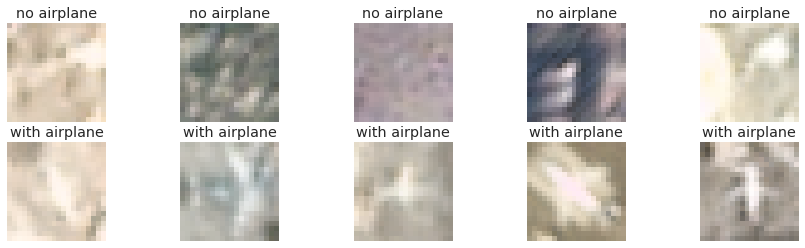

In [ ]:
plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + files_sign0[i] + '.png')
    plt.imshow(img)
    plt.title('no airplane')

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + files_sign1[i] + '.png')
    plt.imshow(img)
    plt.title('with airplane')
plt.show();

Очевидно, что по таким изображениям человеку тяжело определить наличие самолета на изображении.

Заглянем в тестовые выборки. Разумеется в реальных условиях это сделать невозможно, но, поскольку, в обучении эта информация использована не будет, хотя бы убедимся, что тестовая выборка содержит схожие с обучающей выборкой изображения.

In [ ]:
df_test = pd.read_csv('/content/data/test.csv')
df_test.sample(5)

,filename
335,80ef990a-2055-42ba-92fc-4d422255bf5c
830,2462c695-9bea-4496-be6d-fe38ceefccbf
306,0f61ddf2-c03e-48e6-85ce-c621457e0657
16,ff213bfe-62ce-4d61-9188-91caabab7977
263,32777d03-6ddd-4779-a9f1-5a9c1120ebb7


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


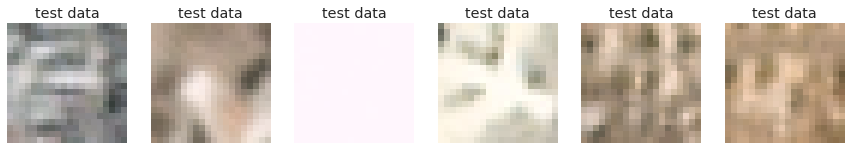

In [ ]:
plt.figure(figsize=(15,4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    img = Image.open(TEST_DATA + df_test.filename[i] + '.png')
    plt.imshow(img)
    plt.title('test data')

Очевидно, что человек не сможет визуально определить, есть самолет на этих изображениях или нет.

In [ ]:
df_up_test = pd.read_csv('/content/data/test_extended')
df_up_test.sample(5)

,filename
10066,7d6b833f-6cb2-4da4-8743-d7bbca8dc2c6
69271,27d55dad-1d86-4bad-8e91-e91c9a4276ec
57032,9a676fe3-fb65-4ad0-8361-da1ed07f56f9
80097,f0b17cfc-383b-45a5-bf7f-1b591be6f8c5
8447,7fe6d0fb-5397-4c4f-b152-f19f31cd2486


In [ ]:
df_up_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101000 entries, 0 to 100999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  101000 non-null  object
dtypes: object(1)
memory usage: 789.2+ KB


Получается, что в test_extended включены обе тестовые выборки

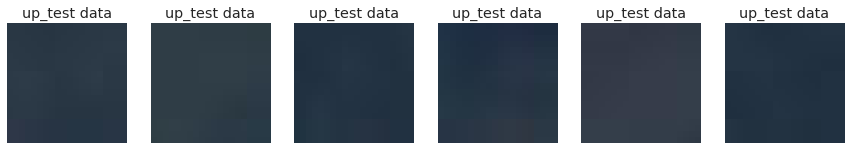

In [ ]:
plt.figure(figsize=(15,4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    img = Image.open(UP_TEST_DATA + up_test_stat.name[i])
    plt.imshow(img)
    plt.title('up_test data')

По первым 6 образцам тестовых выборок можно предполагать, что они различаются не только расширением файлов

## Загрузка и предобработка данных

Разделим обучающую выборку на обучающую и валидационную выборку

In [ ]:
X_train = df_train.filename.to_numpy()
Y_train = df_train.sign.to_numpy(dtype='float32').reshape(-1,1)
up_test_files = df_up_test.filename.to_numpy()

train_files, val_files, train_labels, val_labels = train_test_split(X_train, Y_train, test_size=0.2, \
                                                                    stratify=Y_train, random_state=42
                                                                    )

Создадим класс для создания датасетов

In [ ]:
class AirDataset(Dataset):
    def __init__(self, mode, files, labels=None):
        super().__init__()
        
        self.files = files
        self.labels = labels
        self.mode = mode

        DATA_MODES = ['train', 'val', 'test']

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def load_sample(self, file, mode):
        if mode == 'test':          
          try:
            path = os.path.join(UP_TEST_DATA, file + '.jpeg')
            image = Image.open(path)
            image.load()
          except FileNotFoundError:
            path = os.path.join(TEST_DATA, file + '.png')
            image = Image.open(path)
            image.load()
        else:
          path = os.path.join(TRAIN_DATA, file + '.png')
          image = Image.open(path)
          image.load()
          
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        image_transforms = {
                      # Train uses data augmentation
                      'train':
                      transforms.Compose([
                          # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                          # transforms.RandomPerspective(distortion_scale=0.1),
                          # transforms.RandomRotation(degrees=15),
                          # transforms.ColorJitter(),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomVerticalFlip(),
                          # transforms.CenterCrop(size=RESCALE_SIZE),  # Imagenet standards
                          transforms.ToTensor()
                          # transforms.Normalize([0.485, 0.456, 0.406],
                                              # [0.229, 0.224, 0.225])  # Imagenet standards
                      ]),
                      # Validation does not use augmentation
                      'val':
                      # transforms.Compose([
                      #     transforms.Resize(size=256),
                      #     transforms.CenterCrop(size=RESCALE_SIZE),
                      #     transforms.ToTensor(),
                      #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      # ]),
                      transforms.ToTensor(),

                      # Test does not use augmentation
                      'test':
                      # transforms.Compose([
                      #     transforms.Resize(size=256),
                      #     transforms.CenterCrop(size=RESCALE_SIZE),
                      #     transforms.ToTensor(),
                      #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      # ]),
                      transforms.ToTensor(),
        }

        x = self.load_sample(self.files[index], self.mode)   

        # В зависимости от состояния возвращаем или нет класс и разные трансформации x
        if self.mode == 'train':
            x = image_transforms['train'](x)
            label = self.labels[index]            
            return x, label

        elif self.mode == 'val':
            x = image_transforms['val'](x)
            label = self.labels[index]
            return x, label

        else:
            x = image_transforms['test'](x)
            return x

Создадим датасеты и Dataloaders

In [ ]:
train_dataset = AirDataset('train', train_files, train_labels)
val_dataset = AirDataset('val', val_files, val_labels)
test_dataset = AirDataset('test', up_test_files)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=200, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

## Модель

In [ ]:
airmodel = nn.Sequential(
    # in: 3 x 20 x 20
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 20 x 20

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 20 x 20

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 20 x 20

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 10 x 10

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=2, padding_mode='reflect'),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 6 x 6

    nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 6 x 6

    nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=2, padding_mode='reflect'),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 128, kernel_size=4, stride=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 1 x 1

    nn.Flatten(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=1),
    nn.Sigmoid()
)

In [ ]:
with torch.no_grad():
  input = torch.randn((2,3,20,20))
  output = airmodel(input)
output.shape

torch.Size([2, 1])

## Функция обучения

In [ ]:
def train_model(train_loader, val_loader, model, epochs, criterion, optimizer, start=1):
    since = time()
    best_loss = 100

    # loss per epoch
    train_losses = []
    val_losses = []
    train_rocauc = []
    val_rocauc = []

    for epoch in tqdm(range(epochs)):
        set_seed(86 + epoch)

        # train--------------------------
        model.train()                
        running_loss = 0
        processed_data = 0
        tr_labels = torch.Tensor()
        tr_preds = torch.Tensor()

        for inputs, labels in train_loader:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          processed_data += inputs.size(0)

          tr_labels = torch.cat((tr_labels, labels.detach().cpu()), dim=0)
          tr_preds = torch.cat((tr_preds, outputs.detach().cpu()), dim=0)

          optimizer.zero_grad()

        train_loss = running_loss / processed_data
        train_losses.append(train_loss)
        tr_rocauc = roc_auc_score(tr_labels.numpy(), tr_preds.numpy())
        train_rocauc.append(tr_rocauc)


        # val--------------------------
        model.eval()
        running_loss = 0
        processed_data = 0
        val_labels = torch.Tensor()
        val_preds = torch.Tensor()

        with torch.no_grad():
          for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0) 

            val_labels = torch.cat((val_labels, labels.detach().cpu()), dim=0)
            val_preds = torch.cat((val_preds, outputs.detach().cpu()), dim=0)         

        val_loss = running_loss / processed_data
        val_losses.append(val_loss)
        vl_rocauc = roc_auc_score(val_labels.numpy(), val_preds.numpy())
        val_rocauc.append(vl_rocauc)

        # save best model-------------------------------
        if best_loss > val_losses[-1]:
            best_loss = val_losses[-1]
            best_v_loss = val_losses[-1]
            best_t_loss = train_losses[-1]
            best_t_auc = train_rocauc[-1]
            best_v_auc = val_rocauc[-1]
            torch.save(model.state_dict(), 
                       os.path.join(MODELS, 'best_airmodel_epoch_' + str(epoch + start) + '.pth'))
            best_epoch = epoch + start
            best_time = time() - since

        # save current model
        if (epoch + start) % 5 == 0:
            torch.save(model.state_dict(), 
                   os.path.join(MODELS, 'last_airmodel_epoch_' + str(epoch + start) + '.pth'))
        
        # Visualize metrics---------------------------------
        clear_output(wait=True)
        plt.figure(figsize=(15,8))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="t_loss")
        plt.plot(val_losses, label="v_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_rocauc, label="t_rocauc")
        plt.plot(val_rocauc, label="v_rocauc")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("rocauc")

        plt.suptitle(f'{epoch + start} / {epochs + start-1} - t loss: {train_losses[-1]:.4f} - v loss: {val_losses[-1]:.4f} \
                     - t_rocauc: {train_rocauc[-1]:.6f} - v_rocauc: {val_rocauc[-1]:.6f}',
                     fontsize=16)        
        plt.show();

    # final ----------------------------------------------------------
    torch.save(model.state_dict(), 
                   os.path.join(MODELS, 'last_airmodel_epoch_' + str(epochs + start-1) + '.pth'))
    
    # save metrics
    dict_metrics = {
        'traint_losses': train_losses,
        'val_losses': val_losses,
        'traint_rocauc': train_rocauc,
        'val_rocauc': val_rocauc
    }
    with open(os.path.join(METRICS, 'airmodel_loss_rocauc_epoch_' + str(epochs + start) + '.pickle'), 'wb') as f:
        pickle.dump(dict_metrics, f)


    print("Training is done! Epoch [{}/{}], full time: {} min, \
          ".format(
            epoch+start, epochs+start, 
            (time() - since)//60
            )
    )

    print("Best_epoch [{}/{}], best_v_loss: {:.4f}, best_t_loss: {:.4f}, \
          best_t_auc: {:.6f}, best_v_auc: {:.6f}, best_time: {} min, \
          ".format(
            best_epoch, epochs+start, 
            best_v_loss, best_t_loss, 
            best_t_auc, best_t_auc, 
            best_time//60
            )
    )

    return model

## Обучение модели

In [ ]:
airmodel_40 = airmodel.to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.AdamW(airmodel_40.parameters())
epochs = 40

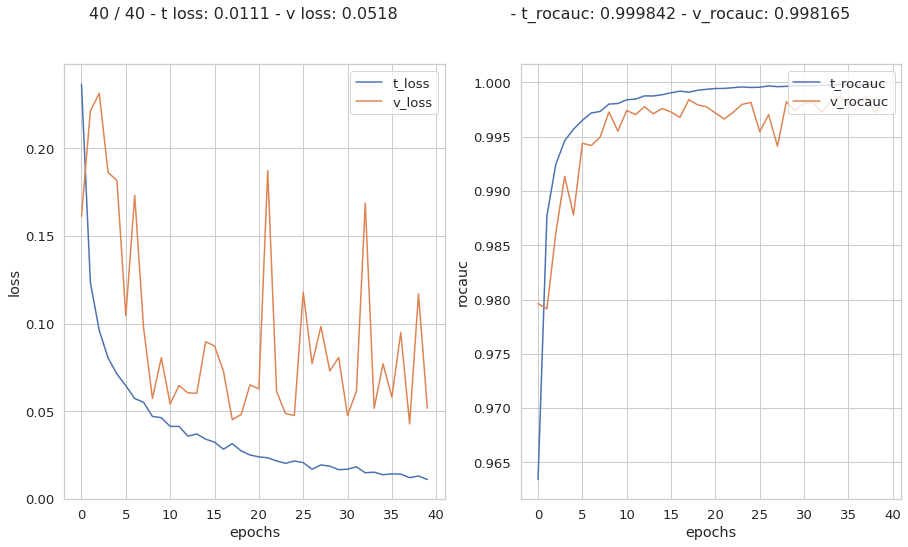

100%|██████████| 40/40 [51:24<00:00, 77.10s/it]


Training is done! Epoch [40/41], full time: 51.0 min,           
Best_epoch [38/41], best_v_loss: 0.0428, best_t_loss: 0.0121,           best_t_auc: 0.999815, best_v_auc: 0.999815, best_time: 48.0 min,           


In [ ]:
airmodel_40 = train_model(train_loader, val_loader, airmodel_40, epochs, criterion, optimizer, start=1)

## Предсказания

In [ ]:
def test_predict(model, data_loader):
    set_seed(42)
    with torch.no_grad():
        logits = []
    
        for inputs in data_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            # outputs = (outputs > 0.5).int()
            logits.append(outputs)
            
    probs = torch.cat(logits).numpy()
    return probs

In [ ]:
def submit_df(model, test_loader, num_subm=1):
  probs = test_predict(model, test_loader)
  df_test = pd.read_csv('/content/data/test_extended')
  df_test['sign'] = probs
  df_test = df_test[['sign', 'filename']]
  df_test.to_csv(os.path.join(SUBMITS, 'sub_' + str(num_subm) + '.csv'), index=False)

In [ ]:
# Лучшие предсказания на валидационной выборке были на 38 эпохе. Загрузим веса модели.
airmodel_best = airmodel.to(DEVICE)
airmodel_best.load_state_dict(torch.load(os.path.join(MODELS, 'best_airmodel_epoch_38.pth')))

<All keys matched successfully>

In [ ]:
submit_df(airmodel_best, test_loader, num_subm=1)

Результат\
Public  0.992583656152002

Private 0.9980898607484769


## Анализ ошибок модели

In [ ]:
def val_predict(model, data_loader):
    set_seed(42)
    with torch.no_grad():
        logits = []
        signs = []
    
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            # outputs = (outputs > 0.5).int()
            logits.append(outputs)
            signs.append(labels)
            
    probs = torch.cat(logits)
    signs = torch.cat(signs)
    predicts = torch.cat((signs, probs), dim=1)
    return predicts

In [ ]:
def frame_label_predict(model, data_loader, data_files):
  predict_labels = val_predict(model, data_loader)
  df_dict = {
    'files': data_files,
    'labels': predict_labels[:, 0].numpy(),
    'probs': predict_labels[:, 1].numpy()
  }
  df_predict = pd.DataFrame(df_dict)

  return df_predict

Посмотрим, на каких изображениях из валидационной выборки модель ошибается

In [ ]:
# Лучшие предсказания на валидационной выборке были на 38 эпохе. Загрузим веса модели.
airmodel_38 = airmodel.to(DEVICE)
airmodel_38.load_state_dict(torch.load(os.path.join(MODELS, 'best_airmodel_epoch_38.pth')))

<All keys matched successfully>

In [ ]:
df_val_predict = frame_label_predict(airmodel_38, val_loader, val_files)

In [ ]:
# Посчитаем ошибочные предсказания

false_1_v = df_val_predict[(df_val_predict.labels == 0) & (df_val_predict.probs > 0.5)].reset_index()
false_0_v = df_val_predict[(df_val_predict.labels == 1) & (df_val_predict.probs < 0.5)].reset_index()

print(f'Самолета нет, а модель считает, что есть на {false_1_v.shape[0]} снимках')
print(f'Самолет есть, а модель считает, что нет на {false_0_v.shape[0]} снимках')

Самолета нет, а модель считает, что есть на 33 снимках
Самолет есть, а модель считает, что нет на 55 снимках


Посмотрим визуально на эти изображения

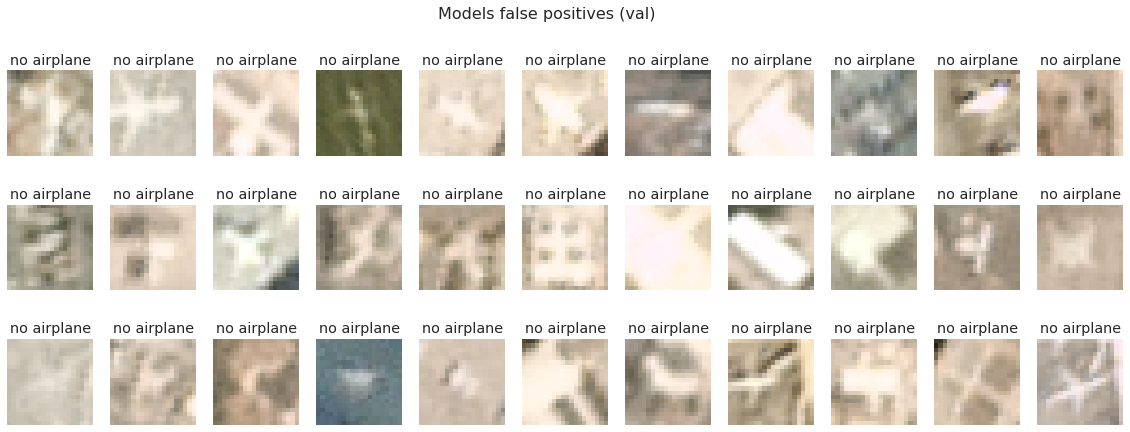

In [ ]:
plt.figure(figsize=(20,7))
for i in range(33):
    plt.subplot(3, 11, i+1)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + false_1_v.files[i] + '.png')
    plt.imshow(img)
    plt.title('no airplane')

plt.suptitle('Models false positives (val)', fontsize=16)
# plt.tight_layout()
plt.show();

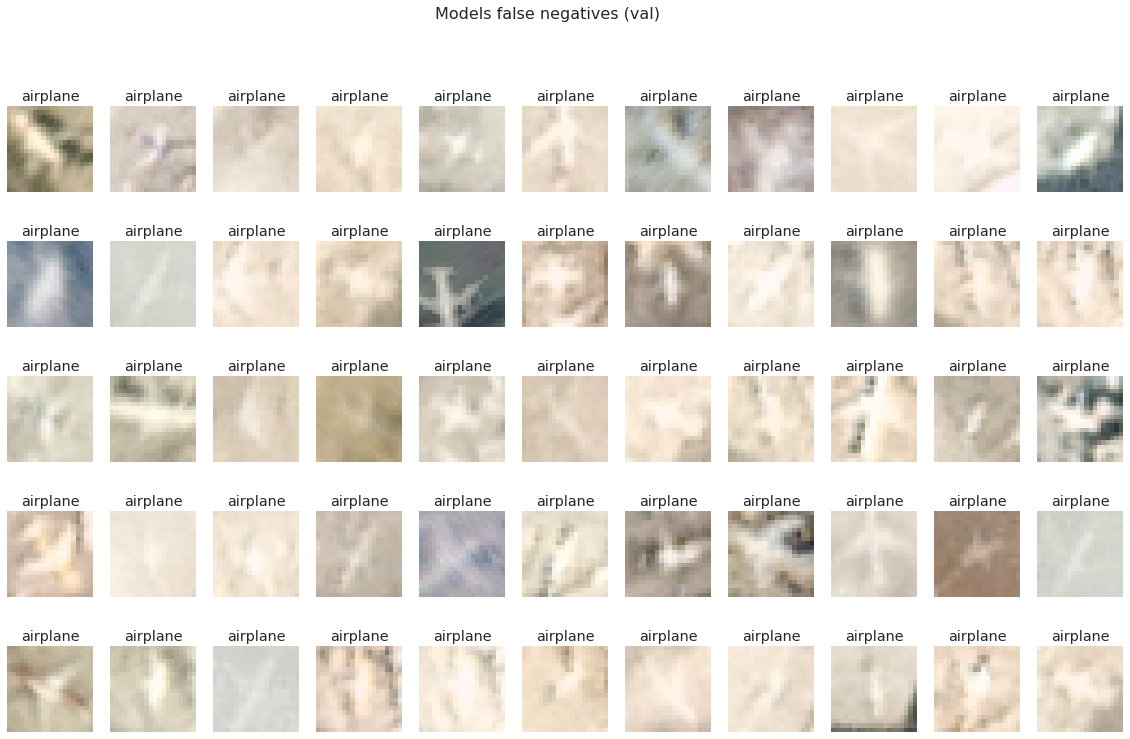

In [ ]:
plt.figure(figsize=(20,12))
for i in range(55):
    plt.subplot(5, 11, i+1)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + false_0_v.files[i] + '.png')
    plt.imshow(img)
    plt.title('airplane')

plt.suptitle('Models false negatives (val)', fontsize=16)
# plt.tight_layout()
plt.show();

Судя по всему в разметке присутствуют ошибки. Модель предсказывает самолет там, где визуально он действительно наблюдается. Имеет смысл посмотреть ошибки на обучающей выборке и удалить изображения с неверной разметкой. После этого снвоа продолжить обучение.\
Сделаем предсказания текущей лучшей моделью, а потом попробуем почистить обучающую и валидационную выборку.

Посмотрим, где ошибается модель на обучающей выборке

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=False)
df_train_predict = frame_label_predict(airmodel_38, train_loader, train_files)

In [ ]:
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
# Посчитаем ошибочные предсказания
false_1_tr = df_train_predict[(df_train_predict.labels == 0.0) & (df_train_predict.probs > 0.5)].reset_index()
false_0_tr = df_train_predict[(df_train_predict.labels == 1.0) & (df_train_predict.probs < 0.5)].reset_index()

print(f'Самолета нет, а модель считает, что есть на {false_1_tr.shape[0]} снимках')
print(f'Самолет есть, а модель считает, что нет на {false_0_tr.shape[0]} снимках')

Самолета нет, а модель считает, что есть на 64 снимках
Самолет есть, а модель считает, что нет на 128 снимках


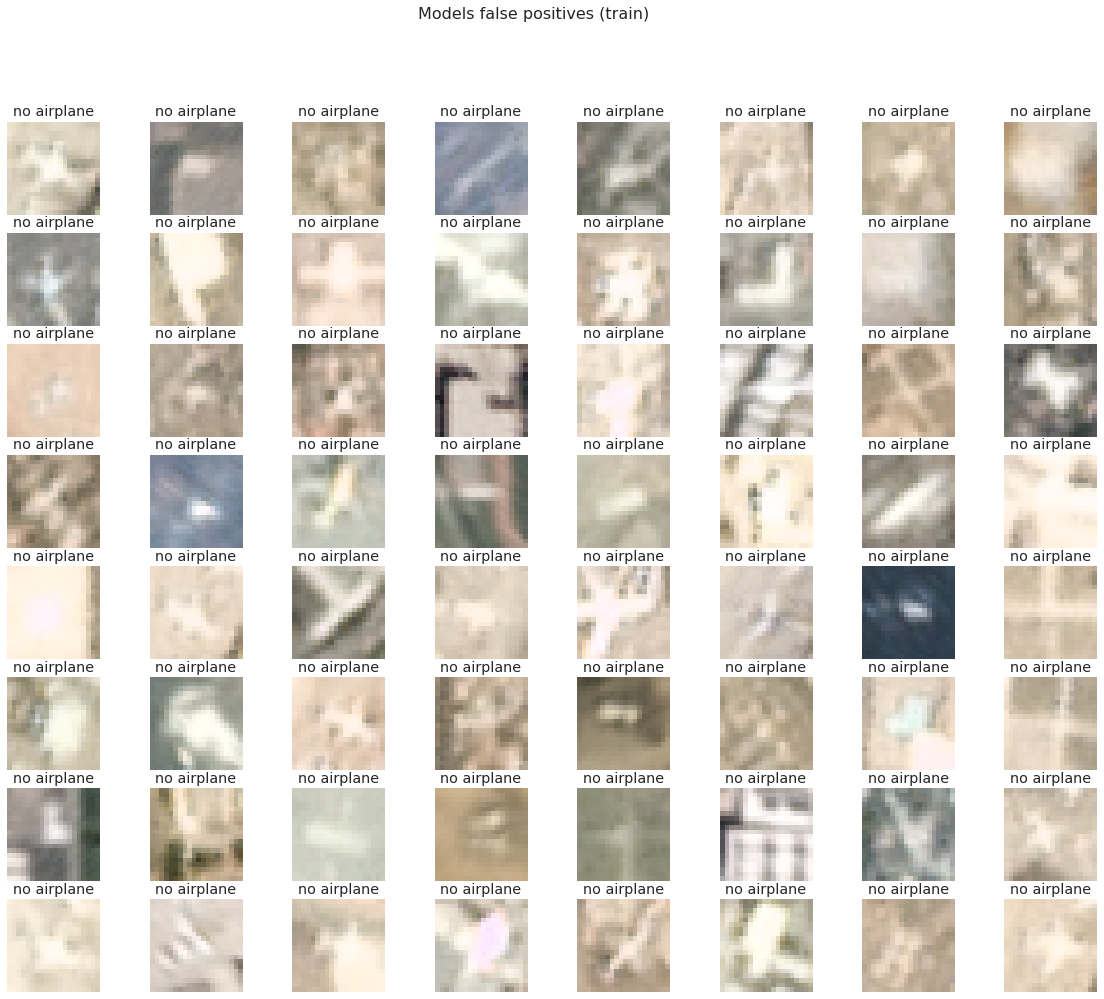

In [ ]:
plt.figure(figsize=(20,16))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + false_1_tr.files[i] + '.png')
    plt.imshow(img)
    plt.title('no airplane')

plt.suptitle('Models false positives (train)', fontsize=16)
# plt.tight_layout()
plt.show();

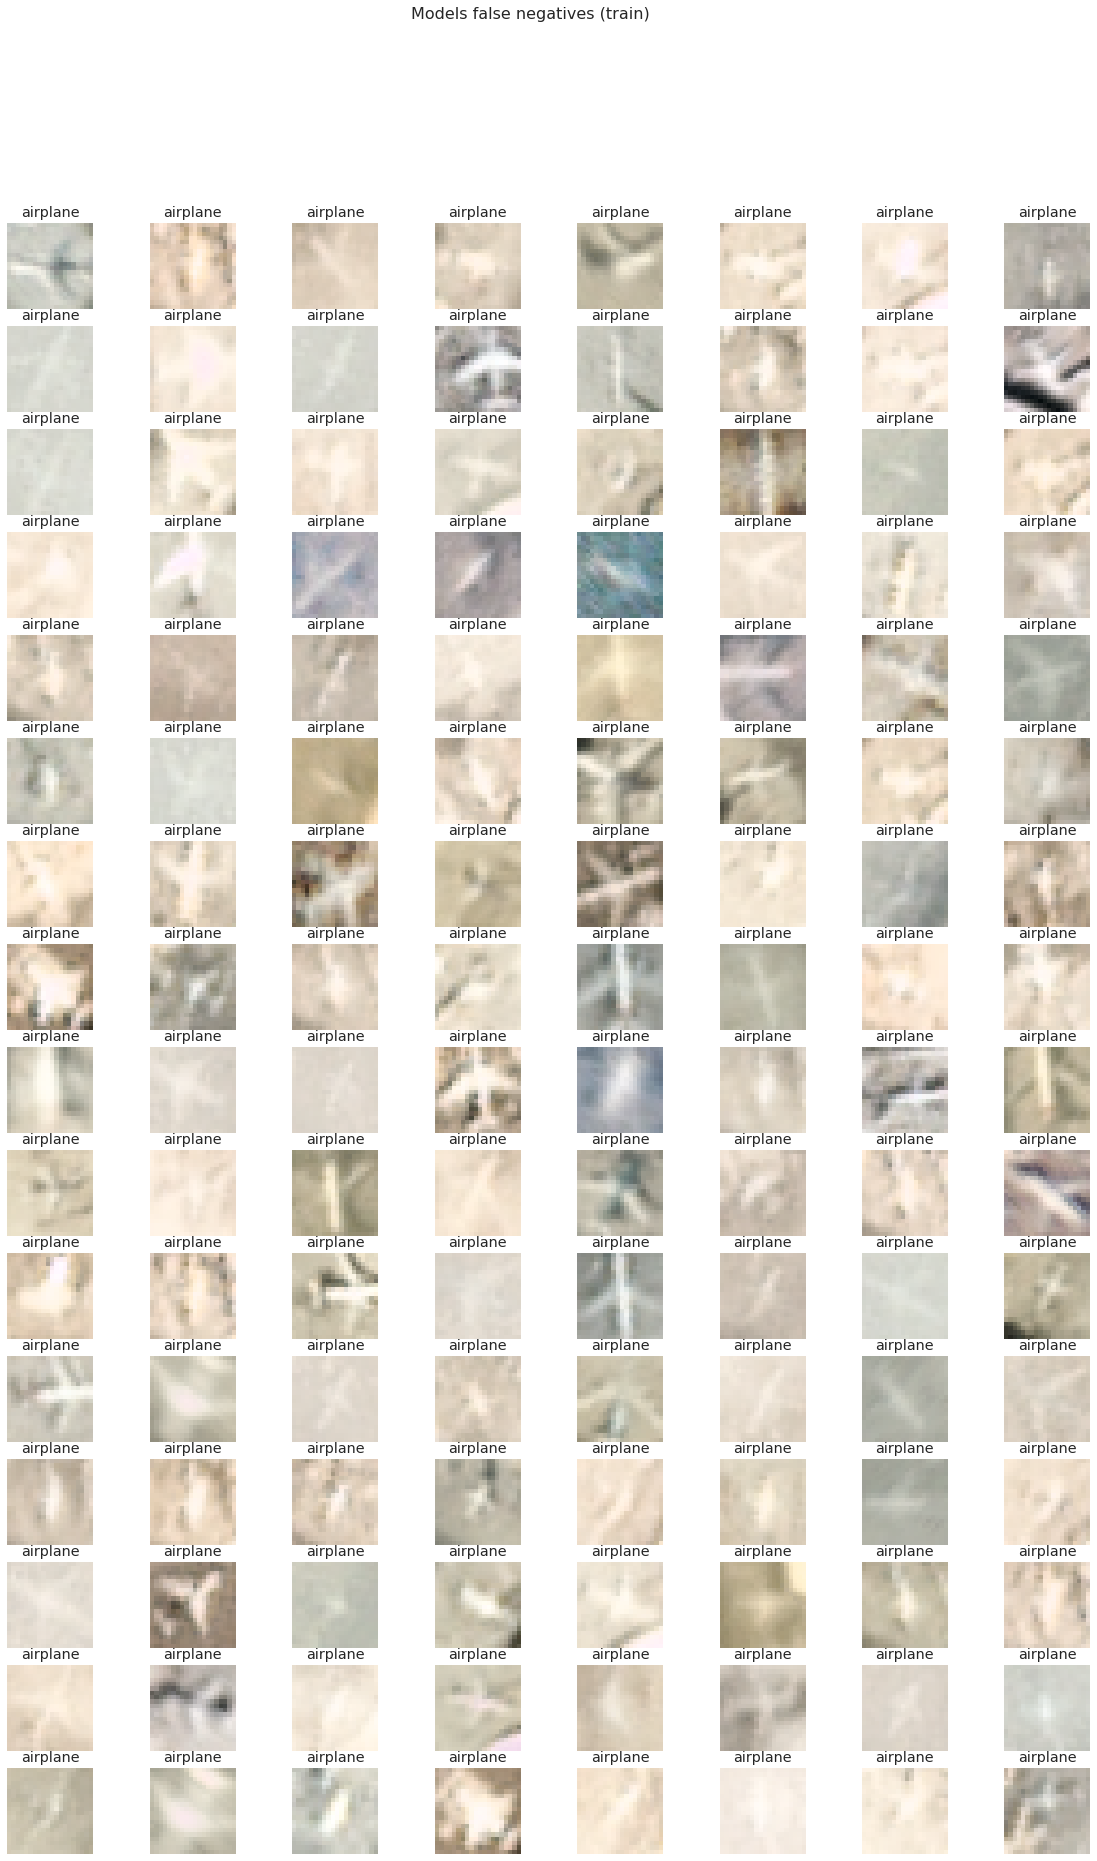

In [ ]:
plt.figure(figsize=(20,30))
for i in range(128):
    plt.subplot(16, 8, i+1)
    plt.axis("off")
    img = Image.open(TRAIN_DATA + false_0_tr.files[i] + '.png')
    plt.imshow(img)
    plt.title('airplane')

plt.suptitle('Models false negatives (train)', fontsize=16)
# plt.tight_layout()
plt.show();

Уберем из обучающей и валидацонной выборок изображения, где модель считает, что самолет есть, но в разметке указано, что нет.

In [ ]:
train_labels.flatten().shape, train_files.shape

((24864,), (24864,))

In [ ]:
tr_dict = {'files': train_files,
           'labels': train_labels.flatten()
           }

v_dict = {'files': val_files,
           'labels': val_labels.flatten()
           }
prev_train_data = pd.DataFrame(tr_dict)
prev_val_data = pd.DataFrame(v_dict)

In [ ]:
prev_train_data.shape, prev_val_data.shape

((24864, 2), (6216, 2))

In [ ]:
new_train_data = prev_train_data[~prev_train_data.files.isin(false_1_tr.files)]
new_val_data = prev_val_data[~prev_val_data.files.isin(false_1_v.files)]

## Обучение с очищенными датасетами

In [ ]:
# Соберем новые Dataloaders
train_dataset = AirDataset('train', 
                           new_train_data.files.to_numpy(), 
                           new_train_data.labels.to_numpy(dtype='float32').reshape(-1,1)
                           )
val_dataset = AirDataset('val', 
                         new_val_data.files.to_numpy(), 
                         new_val_data.labels.to_numpy(dtype='float32').reshape(-1,1)
                         )
test_dataset = AirDataset('test', up_test_files)

train_loader = DataLoader(train_dataset, batch_size=200, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [ ]:
# Лучшие предсказания на валидационной выборке были на 38 эпохе. Загрузим веса модели.
airmodel_38 = airmodel.to(DEVICE)
airmodel_38.load_state_dict(torch.load(os.path.join(MODELS, 'best_airmodel_epoch_38.pth')))

<All keys matched successfully>

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(airmodel_38.parameters())
epochs = 40

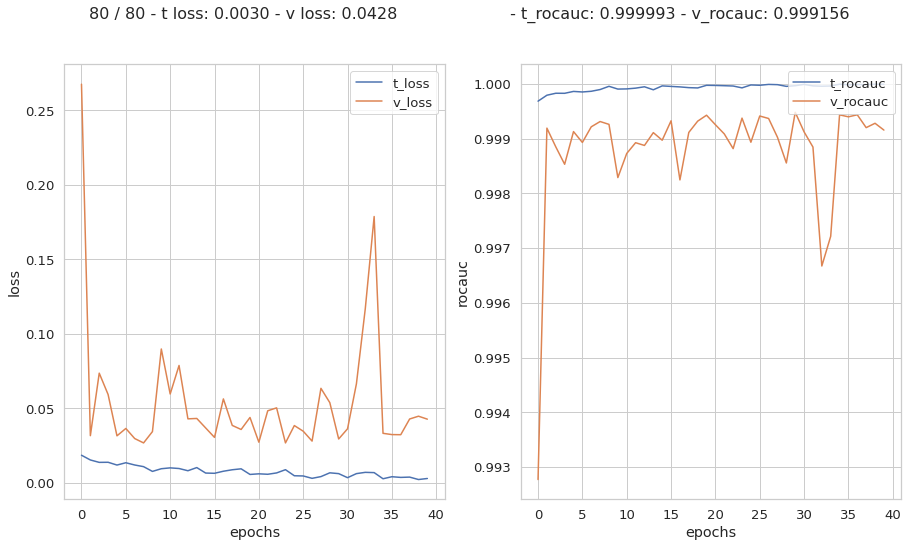

100%|██████████| 40/40 [52:17<00:00, 78.43s/it]


Training is done! Epoch [80/81], full time: 52.0 min,           
Best_epoch [48/81], best_v_loss: 0.0268, best_t_loss: 0.0109,           best_t_auc: 0.999897, best_v_auc: 0.999897, best_time: 10.0 min,           


In [ ]:
airmodel_80 = train_model(train_loader, val_loader, airmodel_38, epochs, criterion, optimizer, start=41)

## Новые предсказания

Сделаем предсказание на последней модели

In [ ]:
airmodel_80 = airmodel.to(DEVICE)
airmodel_80.load_state_dict(torch.load(os.path.join(MODELS, 'last_airmodel_epoch_80.pth')))

<All keys matched successfully>

In [ ]:
submit_df(airmodel_80, test_loader, num_subm=2)

Результат\
Public  0.9949356207341818

Private 0.9999120974760661 (соответствует 25 месту)

Сделаем предсказание на лучшей модели

In [ ]:
airmodel_48 = airmodel.to(DEVICE)
airmodel_48.load_state_dict(torch.load(os.path.join(MODELS, 'best_airmodel_epoch_48.pth')))

<All keys matched successfully>

In [ ]:
submit_df(airmodel_48, test_loader, num_subm=3)

Результат\
Public 0.9955812580704667

Private 0.9994225413402958 (соответствует 29 месту)